In [94]:
#pip install pgeocode

Note: you may need to restart the kernel to use updated packages.


In [1]:
from bs4 import BeautifulSoup
import pandas as pd
import requests 
import pgeocode
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
import seaborn as sns

1. Webscraping the list of the neighbourhoods

In [2]:
link=("https://en.wikipedia.org/wiki/B_postcode_area")

In [3]:
req=requests.get(link)

In [4]:
soup = BeautifulSoup(req.text,'html')


In [5]:
table=soup.find('table', class_= 'wikitable sortable')

In [6]:
pdtable=pd.read_html(str(table))

In [7]:
birmingham_data=pd.DataFrame(pdtable[0])
birmingham_data

,Postcode district,Post town,Coverage,Local authority area(s)
0,B1,BIRMINGHAM,"Birmingham City Centre, Broad Street (east)",Birmingham
1,B2,BIRMINGHAM,"Birmingham City Centre, New Street",Birmingham
2,B3,BIRMINGHAM,"Birmingham City Centre, Newhall Street",Birmingham
3,B4,BIRMINGHAM,"Birmingham City Centre, Corporation Street (no...",Birmingham
4,B5,BIRMINGHAM,"Digbeth, Highgate, Lee Bank",Birmingham
...,...,...,...,...
73,B95,HENLEY-IN-ARDEN,Henley-in-Arden,Stratford-on-Avon
74,B96,REDDITCH,Feckenham,Redditch
75,B97,REDDITCH,"Redditch (west), Callow Hill, Webheath",Redditch
76,B98,REDDITCH,"Redditch (east), Beoley",Redditch


2. Cleaning of the dataframe

In [8]:
birmingham_data=birmingham_data[birmingham_data['Post town'] =="BIRMINGHAM"]

In [9]:
birmingham_data.drop(['Local authority area(s)'], axis=1, inplace=True)
birmingham_data.dropna(inplace=True)
birmingham_data.reset_index(drop=True, inplace=True)


C:\Users\costa\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\costa\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
birmingham_data.rename(columns={'Postcode district':'postal_code', 'Coverage':'Neighborhood'}, inplace=True)

C:\Users\costa\anaconda3\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [11]:
birmingham_data.head()

,postal_code,Post town,Neighborhood
0,B1,BIRMINGHAM,"Birmingham City Centre, Broad Street (east)"
1,B2,BIRMINGHAM,"Birmingham City Centre, New Street"
2,B3,BIRMINGHAM,"Birmingham City Centre, Newhall Street"
3,B4,BIRMINGHAM,"Birmingham City Centre, Corporation Street (no..."
4,B5,BIRMINGHAM,"Digbeth, Highgate, Lee Bank"


3. Collecting latitude and longitude

In [12]:
nomi = pgeocode.Nominatim('GB')

In [13]:
p=('B1','B2' ,'B3','B4','B5','B6','B7','B8','B9','B10','B11','B12','B13','B14','B15','B16','B17',
                       'B18','B19','B20','B21','B23','B24','B25','B26','B27','B28','B29',
                    'B30','B31','B32','B33','B34','B35','B36',
                       'B37','B38','B40','B42','B43','B44','B45','B46','B47','B48')


In [14]:
L_L=nomi.query_postal_code(p)
L_L.head()

,postal_code,country code,place_name,state_name,state_code,county_name,county_code,community_name,community_code,latitude,longitude,accuracy
0,B1,GB,Birmingham,England,ENG,West Midlands,2634343,NaN,NaN,52.4814,-1.8998,4.0
1,B2,GB,Birmingham,England,ENG,West Midlands,2634343,NaN,NaN,52.4814,-1.8998,4.0
2,B3,GB,Birmingham,England,ENG,West Midlands,2634343,NaN,NaN,52.4814,-1.8998,4.0
3,B4,GB,Birmingham,England,ENG,West Midlands,2634343,NaN,NaN,52.4814,-1.8998,4.0
4,B5,GB,Birmingham,England,ENG,West Midlands,2634343,NaN,NaN,52.4814,-1.8998,4.0


4. Integration of latitude and longitude in the neighbourhoods dataframe

In [15]:
L_L.drop(columns=['country code','place_name','state_name','state_code','county_name','county_code',
        'community_name','community_code','accuracy'], inplace=True)

In [16]:
L_L.rename(columns={'latitude':'Latitude','longitude':'Longitude'}, inplace=True)

In [17]:
b_data=birmingham_data.join(L_L.set_index('postal_code'), on='postal_code')
b_data.head()

,postal_code,Post town,Neighborhood,Latitude,Longitude
0,B1,BIRMINGHAM,"Birmingham City Centre, Broad Street (east)",52.4814,-1.8998
1,B2,BIRMINGHAM,"Birmingham City Centre, New Street",52.4814,-1.8998
2,B3,BIRMINGHAM,"Birmingham City Centre, Newhall Street",52.4814,-1.8998
3,B4,BIRMINGHAM,"Birmingham City Centre, Corporation Street (no...",52.4814,-1.8998
4,B5,BIRMINGHAM,"Digbeth, Highgate, Lee Bank",52.4814,-1.8998


5 Connecting to Foursquare and getting info about the venues

In [18]:
CLIENT_ID = 'SVONWUW2CIODQNCTWJL4Q0HB02QPI0OWKO5YIYXY5ZTVUWHE' # your Foursquare ID
CLIENT_SECRET = 'YQWOGGXOUF34GTPCHP25ESLBK5KWURVMGOWAVL2QPRM2DX5T' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT=100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: SVONWUW2CIODQNCTWJL4Q0HB02QPI0OWKO5YIYXY5ZTVUWHE
CLIENT_SECRET:YQWOGGXOUF34GTPCHP25ESLBK5KWURVMGOWAVL2QPRM2DX5T


In [19]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [20]:
birmingham_venues=getNearbyVenues(names=b_data['Neighborhood'],
                                   latitudes=b_data['Latitude'],
                                   longitudes=b_data['Longitude']
                                  )

Birmingham City Centre, Broad Street (east)
Birmingham City Centre, New Street
Birmingham City Centre, Newhall Street
Birmingham City Centre, Corporation Street (north)
Digbeth, Highgate, Lee Bank
Aston, Birchfield, Birmingham , Witton
Nechells, Vauxhall
Washwood Heath, Ward End, Saltley
Bordesley Green, Bordesley
Small Heath
Sparkhill, Sparkbrook, Tyseley
Balsall Heath, Sparkbrook, Highgate
Moseley, Billesley
Kings Heath, Yardley Wood, Druids Heath, Highter's Heath, Warstock
Edgbaston,
Ladywood
Harborne, Edgbaston
Winson Green, Hockley
Lozells, Newtown, Birchfield
Handsworth Wood, Handsworth, Birchfield
Handsworth
Erdington, Stockland Green, Short Heath, Perry Common
Erdington, Wylde Green, Tyburn
Yardley
Sheldon, Yardley
Acocks Green
Hall Green
Selly Oak, Bournbrook, Selly Park, Weoley Castle, California (part of)
Bournville, Cotteridge, Stirchley
Northfield, Longbridge, West Heath
Woodgate, Bartley Green, Quinton, California (part of)
Kitts Green, Stechford
Shard End, Buckland End
C

In [21]:
birmingham_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Birmingham City Centre, Broad Street (east)",52.4814,-1.8998,Loki Wine Merchant & Tasting House,52.482015,-1.897398,Wine Shop
1,"Birmingham City Centre, Broad Street (east)",52.4814,-1.8998,Adams,52.479797,-1.901482,Restaurant
2,"Birmingham City Centre, Broad Street (east)",52.4814,-1.8998,Asha's Contemporary Indian Cuisine,52.481398,-1.901992,Indian Restaurant
3,"Birmingham City Centre, Broad Street (east)",52.4814,-1.8998,200 Degrees Coffee,52.481784,-1.898328,Coffee Shop
4,"Birmingham City Centre, Broad Street (east)",52.4814,-1.8998,The Colmore,52.480509,-1.901431,Pub


In [22]:
birmingham_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Acocks Green,11,11,11,11,11,11
"Aston, Birchfield, Birmingham , Witton",7,7,7,7,7,7
"Balsall Heath, Sparkbrook, Highgate",67,67,67,67,67,67
"Birmingham City Centre, Broad Street (east)",67,67,67,67,67,67
"Birmingham City Centre, Corporation Street (north)",67,67,67,67,67,67
"Birmingham City Centre, New Street",67,67,67,67,67,67
"Birmingham City Centre, Newhall Street",67,67,67,67,67,67
"Bordesley Green, Bordesley",4,4,4,4,4,4
"Bournville, Cotteridge, Stirchley",2,2,2,2,2,2


In [23]:
birmingham_venues['Venue Category'].unique()[:50]

array(['Wine Shop', 'Restaurant', 'Indian Restaurant', 'Coffee Shop',
       'Pub', 'Beer Bar', 'South American Restaurant',
       'Italian Restaurant', 'Vegetarian / Vegan Restaurant',
       'Sandwich Place', 'Bar', 'Shopping Mall', 'Bistro', 'Gaming Cafe',
       'Bakery', 'History Museum', 'Doner Restaurant',
       'English Restaurant', 'Plaza', 'Brazilian Restaurant', 'Café',
       'Concert Hall', 'Cosmetics Shop', 'Argentinian Restaurant',
       'Clothing Store', 'Department Store', 'Gym / Fitness Center',
       'Fried Chicken Joint', 'Juice Bar', 'Monument / Landmark',
       'Yoga Studio', 'Furniture / Home Store', 'Asian Restaurant',
       'Hotel', 'Gym', 'Soccer Stadium', 'Soccer Field', 'Park',
       'Grocery Store', 'Convenience Store', 'Arts & Crafts Store',
       'Supermarket', 'Bank', 'Turkish Restaurant',
       'Middle Eastern Restaurant', 'Gas Station', 'Pakistani Restaurant',
       'Moroccan Restaurant', 'Deli / Bodega', 'Cuban Restaurant'],
      dtype=obje

6 Analyzing and one hot encoding

In [24]:
# one hot encoding
birmingham_onehot = pd.get_dummies(birmingham_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
birmingham_onehot['Neighborhood'] = birmingham_venues['Neighborhood'] 

birmingham_onehot.head()

,ATM,American Restaurant,Argentinian Restaurant,Arts & Crafts Store,Asian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Bakery,Bank,...,Thai Restaurant,Toy / Game Store,Track,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Warehouse Store,Wine Shop,Yoga Studio,Neighborhood
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,"Birmingham City Centre, Broad Street (east)"
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"Birmingham City Centre, Broad Street (east)"
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"Birmingham City Centre, Broad Street (east)"
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"Birmingham City Centre, Broad Street (east)"
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"Birmingham City Centre, Broad Street (east)"


In [25]:
birmingham_grouped = birmingham_onehot.groupby('Neighborhood').mean().reset_index()
birmingham_grouped
birmingham_grouped.shape

(43, 103)

In [26]:
birmingham_italian_restoraunts= birmingham_grouped[["Neighborhood","Italian Restaurant"]]
birmingham_italian_restoraunts.sort_values('Italian Restaurant', ascending=False).head()

,Neighborhood,Italian Restaurant
38,"Sparkhill, Sparkbrook, Tyseley",0.200000
20,"Harborne, Edgbaston",0.181818
12,"Digbeth, Highgate, Lee Bank",0.044776
6,"Birmingham City Centre, Newhall Street",0.044776
41,"Winson Green, Hockley",0.044776


Printing each neighborhood along with the top 5 most common venues

In [27]:
num_top_venues = 5

for hood in birmingham_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = birmingham_grouped[birmingham_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Acocks Green----
             venue  freq
0      Supermarket  0.27
1              Pub  0.18
2  Warehouse Store  0.09
3   Sandwich Place  0.09
4      Coffee Shop  0.09


----Aston, Birchfield, Birmingham , Witton----
            venue  freq
0  Soccer Stadium  0.57
1             Pub  0.14
2            Park  0.14
3    Soccer Field  0.14
4     Outlet Mall  0.00


----Balsall Heath, Sparkbrook, Highgate----
                venue  freq
0         Coffee Shop  0.15
1                 Pub  0.12
2            Beer Bar  0.04
3       Shopping Mall  0.04
4  Italian Restaurant  0.04


----Birmingham City Centre, Broad Street (east)----
                venue  freq
0         Coffee Shop  0.15
1                 Pub  0.12
2            Beer Bar  0.04
3       Shopping Mall  0.04
4  Italian Restaurant  0.04


----Birmingham City Centre, Corporation Street (north)----
                venue  freq
0         Coffee Shop  0.15
1                 Pub  0.12
2            Beer Bar  0.04
3       Shopping Mall  0.04

First, let's write a function to sort the venues in descending order and create the new dataframe and display the top 10 venues for each neighborhood.

In [28]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [29]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = birmingham_grouped['Neighborhood']

for ind in np.arange(birmingham_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(birmingham_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Acocks Green,Supermarket,Pub,Grocery Store,Coffee Shop,Furniture / Home Store,Sandwich Place,Bowling Alley,Warehouse Store,Discount Store,Fish & Chips Shop
1,"Aston, Birchfield, Birmingham , Witton",Soccer Stadium,Pub,Park,Soccer Field,Yoga Studio,Cosmetics Shop,Deli / Bodega,Dentist's Office,Department Store,Discount Store
2,"Balsall Heath, Sparkbrook, Highgate",Coffee Shop,Pub,Indian Restaurant,Italian Restaurant,Bar,Beer Bar,Hotel,Shopping Mall,Clothing Store,Restaurant
3,"Birmingham City Centre, Broad Street (east)",Coffee Shop,Pub,Indian Restaurant,Italian Restaurant,Bar,Beer Bar,Hotel,Shopping Mall,Clothing Store,Restaurant
4,"Birmingham City Centre, Corporation Street (no...",Coffee Shop,Pub,Indian Restaurant,Italian Restaurant,Bar,Beer Bar,Hotel,Shopping Mall,Clothing Store,Restaurant


In [30]:
birmingham_grouped_clustering = birmingham_grouped.drop('Neighborhood', 1)
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(birmingham_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

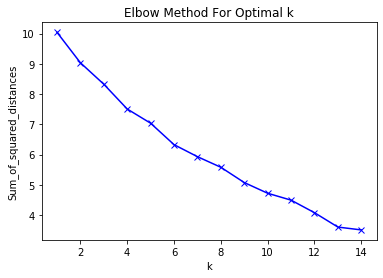

In [31]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [32]:
kclusters = 7

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(birmingham_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 4, 4, 4, 4, 4, 4, 0, 2, 6])

In [33]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [34]:
neighborhoods_venues_sorted.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Acocks Green,Supermarket,Pub,Grocery Store,Coffee Shop,Furniture / Home Store,Sandwich Place,Bowling Alley,Warehouse Store,Discount Store,Fish & Chips Shop
1,4,"Aston, Birchfield, Birmingham , Witton",Soccer Stadium,Pub,Park,Soccer Field,Yoga Studio,Cosmetics Shop,Deli / Bodega,Dentist's Office,Department Store,Discount Store
2,4,"Balsall Heath, Sparkbrook, Highgate",Coffee Shop,Pub,Indian Restaurant,Italian Restaurant,Bar,Beer Bar,Hotel,Shopping Mall,Clothing Store,Restaurant
3,4,"Birmingham City Centre, Broad Street (east)",Coffee Shop,Pub,Indian Restaurant,Italian Restaurant,Bar,Beer Bar,Hotel,Shopping Mall,Clothing Store,Restaurant
4,4,"Birmingham City Centre, Corporation Street (no...",Coffee Shop,Pub,Indian Restaurant,Italian Restaurant,Bar,Beer Bar,Hotel,Shopping Mall,Clothing Store,Restaurant


In [35]:
birmingham_merged = b_data.merge(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
birmingham_merged

,postal_code,Post town,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,B1,BIRMINGHAM,"Birmingham City Centre, Broad Street (east)",52.4814,-1.899800,4,Coffee Shop,Pub,Indian Restaurant,Italian Restaurant,Bar,Beer Bar,Hotel,Shopping Mall,Clothing Store,Restaurant
1,B2,BIRMINGHAM,"Birmingham City Centre, New Street",52.4814,-1.899800,4,Coffee Shop,Pub,Indian Restaurant,Italian Restaurant,Bar,Beer Bar,Hotel,Shopping Mall,Clothing Store,Restaurant
2,B3,BIRMINGHAM,"Birmingham City Centre, Newhall Street",52.4814,-1.899800,4,Coffee Shop,Pub,Indian Restaurant,Italian Restaurant,Bar,Beer Bar,Hotel,Shopping Mall,Clothing Store,Restaurant
3,B4,BIRMINGHAM,"Birmingham City Centre, Corporation Street (no...",52.4814,-1.899800,4,Coffee Shop,Pub,Indian Restaurant,Italian Restaurant,Bar,Beer Bar,Hotel,Shopping Mall,Clothing Store,Restaurant
4,B5,BIRMINGHAM,"Digbeth, Highgate, Lee Bank",52.4814,-1.899800,4,Coffee Shop,Pub,Indian Restaurant,Italian Restaurant,Bar,Beer Bar,Hotel,Shopping Mall,Clothing Store,Restaurant
5,B6,BIRMINGHAM,"Aston, Birchfield, Birmingham , Witton",52.5047,-1.886300,4,Soccer Stadium,Pub,Park,Soccer Field,Yoga Studio,Cosmetics Shop,Deli / Bodega,Dentist's Office,Department Store,Discount Store
6,B7,BIRMINGHAM,"Nechells, Vauxhall",52.4941,-1.872600,5,Convenience Store,Arts & Crafts Store,Sandwich Place,Grocery Store,Fried Chicken Joint,Dentist's Office,Department Store,Discount Store,Doner Restaurant,Electronics Store
7,B8,BIRMINGHAM,"Washwood Heath, Ward End, Saltley",52.4916,-1.859600,4,Pub,Sandwich Place,Park,Bakery,Yoga Studio,Food,Dentist's Office,Department Store,Discount Store,Doner Restaurant
8,B9,BIRMINGHAM,"Bordesley Green, Bordesley",52.4783,-1.850600,0,Supermarket,Furniture / Home Store,Bank,Yoga Studio,Dentist's Office,Department Store,Discount Store,Doner Restaurant,Electronics Store,English Restaurant
9,B10,BIRMINGHAM,Small Heath,52.4698,-1.852300,4,Sandwich Place,Turkish Restaurant,Asian Restaurant,Gym / Fitness Center,Middle Eastern Restaurant,Café,Yoga Studio,Food,Dentist's Office,Department Store


In [36]:
address = 'Birmingham, GB'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Birmingham are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Birmingham are 52.4796992, -1.9026911.


In [49]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(birmingham_merged['Latitude'], birmingham_merged['Longitude'], birmingham_merged['Neighborhood'], birmingham_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [39]:
df=birmingham_italian_restoraunts.copy()
df['Cluster Labels'] = kmeans.labels_
df.sort_values('Italian Restaurant', ascending=False)
df1=df.sort_values('Italian Restaurant', ascending=False)
df1

,Neighborhood,Italian Restaurant,Cluster Labels
38,"Sparkhill, Sparkbrook, Tyseley",0.200000,4
20,"Harborne, Edgbaston",0.181818,4
12,"Digbeth, Highgate, Lee Bank",0.044776,4
6,"Birmingham City Centre, Newhall Street",0.044776,4
41,"Winson Green, Hockley",0.044776,4
26,"Lozells, Newtown, Birchfield",0.044776,4
5,"Birmingham City Centre, New Street",0.044776,4
3,"Birmingham City Centre, Broad Street (east)",0.044776,4
2,"Balsall Heath, Sparkbrook, Highgate",0.044776,4
4,"Birmingham City Centre, Corporation Street (no...",0.044776,4


C:\Users\costa\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


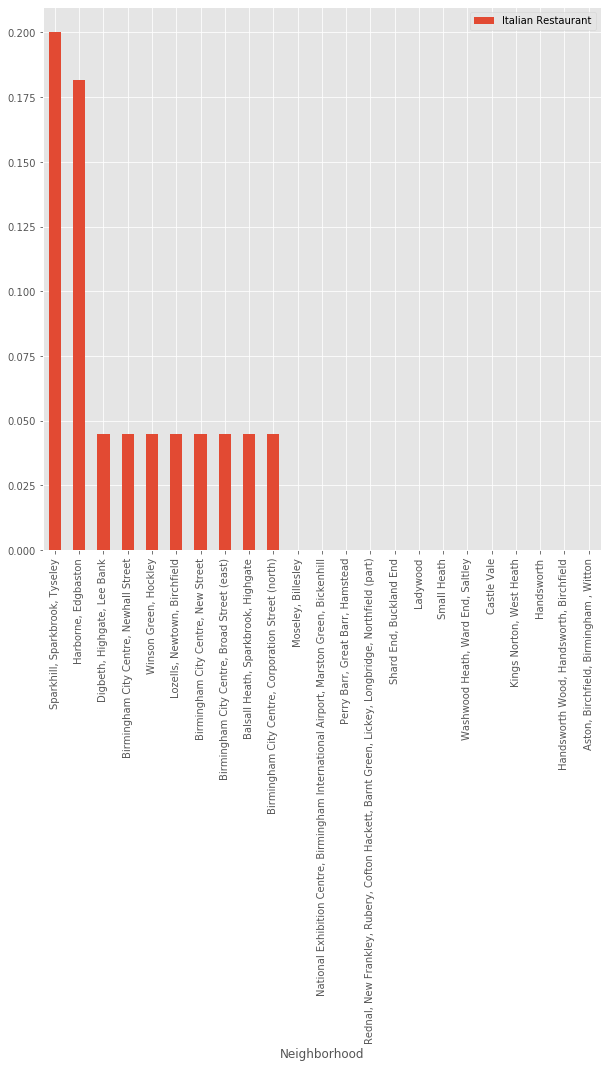

In [40]:
import matplotlib as mpl
mpl.style.use('ggplot')

df2=df1.loc[df1['Cluster Labels'] == 4]
df2.drop('Cluster Labels',axis=1, inplace=True)
df2.set_index('Neighborhood', inplace=True)
df2.plot(kind='bar', figsize=(10,10))


Let's take a look at the clusters

Cluster 0

In [41]:
birmingham_merged.loc[birmingham_merged['Cluster Labels'] == 0, birmingham_merged.columns[[1] + list(range(2, birmingham_merged.shape[1]))]]

,Post town,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,BIRMINGHAM,"Bordesley Green, Bordesley",52.4783,-1.850600,0,Supermarket,Furniture / Home Store,Bank,Yoga Studio,Dentist's Office,Department Store,Discount Store,Doner Restaurant,Electronics Store,English Restaurant
23,BIRMINGHAM,Yardley,52.4666,-1.822750,0,Hotel,Pub,Park,Supermarket,Food,Deli / Bodega,Dentist's Office,Department Store,Discount Store,Doner Restaurant
24,BIRMINGHAM,"Sheldon, Yardley",52.4560,-1.787333,0,Supermarket,Indian Restaurant,Pub,Pet Store,Auto Workshop,Shopping Mall,Fast Food Restaurant,Food,Dentist's Office,Department Store
25,BIRMINGHAM,Acocks Green,52.4447,-1.822900,0,Supermarket,Pub,Grocery Store,Coffee Shop,Furniture / Home Store,Sandwich Place,Bowling Alley,Warehouse Store,Discount Store,Fish & Chips Shop
26,BIRMINGHAM,Hall Green,52.4272,-1.843200,0,Supermarket,Indian Restaurant,Pub,Fried Chicken Joint,Deli / Bodega,Dentist's Office,Department Store,Discount Store,Doner Restaurant,Electronics Store
30,BIRMINGHAM,"Kitts Green, Stechford",52.4804,-1.788300,0,Train Station,Auto Garage,Supermarket,Shop & Service,Yoga Studio,Food,Deli / Bodega,Dentist's Office,Department Store,Discount Store
39,BIRMINGHAM,"Perry Barr, Kingstanding, Great Barr",52.5457,-1.885100,0,Indian Restaurant,Fast Food Restaurant,Furniture / Home Store,Dentist's Office,Department Store,Discount Store,Doner Restaurant,Electronics Store,English Restaurant,Fish & Chips Shop


Cluster 1

In [42]:
birmingham_merged.loc[birmingham_merged['Cluster Labels'] == 1, birmingham_merged.columns[[1] + list(range(2, birmingham_merged.shape[1]))]]

,Post town,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
42,BIRMINGHAM,"Hollywood, Wythall",52.3752,-1.8757,1,Multiplex,Furniture / Home Store,Dentist's Office,Department Store,Discount Store,Doner Restaurant,Electronics Store,English Restaurant,Fast Food Restaurant,Fish & Chips Shop


Cluster 2

In [43]:
birmingham_merged.loc[birmingham_merged['Cluster Labels'] == 2, birmingham_merged.columns[[1] + list(range(2, birmingham_merged.shape[1]))]]

,Post town,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,BIRMINGHAM,"Edgbaston,",52.4623,-1.9212,2,Pizza Place,Lake,Tennis Court,Golf Course,Bar,Yoga Studio,Food,Dentist's Office,Department Store,Discount Store
22,BIRMINGHAM,"Erdington, Wylde Green, Tyburn",52.5194,-1.8090,2,Fast Food Restaurant,Furniture / Home Store,American Restaurant,Pub,Auto Garage,Electronics Store,Outdoor Supply Store,Shopping Plaza,Yoga Studio,Fish & Chips Shop
27,BIRMINGHAM,"Selly Oak, Bournbrook, Selly Park, Weoley Cast...",52.4393,-1.9402,2,Clothing Store,ATM,Supermarket,Platform,Post Office,Pet Store,Electronics Store,Fast Food Restaurant,Liquor Store,Pizza Place
28,BIRMINGHAM,"Bournville, Cotteridge, Stirchley",52.4167,-1.9167,2,Pizza Place,Bar,Yoga Studio,Fried Chicken Joint,Dentist's Office,Department Store,Discount Store,Doner Restaurant,Electronics Store,English Restaurant
29,BIRMINGHAM,"Northfield, Longbridge, West Heath",52.4000,-1.9750,2,Dentist's Office,Pet Store,Cantonese Restaurant,Office,Deli / Bodega,Department Store,Discount Store,Doner Restaurant,Electronics Store,English Restaurant


Cluster 3

In [44]:
birmingham_merged.loc[birmingham_merged['Cluster Labels'] == 3, birmingham_merged.columns[[1] + list(range(2, birmingham_merged.shape[1]))]]

,Post town,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
41,BIRMINGHAM,"Water Orton, Coleshill, Nether Whitacre",52.5332,-1.674783,3,Pub,Fried Chicken Joint,Deli / Bodega,Dentist's Office,Department Store,Discount Store,Doner Restaurant,Electronics Store,English Restaurant,Fast Food Restaurant


Cluster 4

In [45]:
birmingham_merged.loc[birmingham_merged['Cluster Labels'] == 4, birmingham_merged.columns[[1] + list(range(2, birmingham_merged.shape[1]))]]

,Post town,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,BIRMINGHAM,"Birmingham City Centre, Broad Street (east)",52.4814,-1.89980,4,Coffee Shop,Pub,Indian Restaurant,Italian Restaurant,Bar,Beer Bar,Hotel,Shopping Mall,Clothing Store,Restaurant
1,BIRMINGHAM,"Birmingham City Centre, New Street",52.4814,-1.89980,4,Coffee Shop,Pub,Indian Restaurant,Italian Restaurant,Bar,Beer Bar,Hotel,Shopping Mall,Clothing Store,Restaurant
2,BIRMINGHAM,"Birmingham City Centre, Newhall Street",52.4814,-1.89980,4,Coffee Shop,Pub,Indian Restaurant,Italian Restaurant,Bar,Beer Bar,Hotel,Shopping Mall,Clothing Store,Restaurant
3,BIRMINGHAM,"Birmingham City Centre, Corporation Street (no...",52.4814,-1.89980,4,Coffee Shop,Pub,Indian Restaurant,Italian Restaurant,Bar,Beer Bar,Hotel,Shopping Mall,Clothing Store,Restaurant
4,BIRMINGHAM,"Digbeth, Highgate, Lee Bank",52.4814,-1.89980,4,Coffee Shop,Pub,Indian Restaurant,Italian Restaurant,Bar,Beer Bar,Hotel,Shopping Mall,Clothing Store,Restaurant
5,BIRMINGHAM,"Aston, Birchfield, Birmingham , Witton",52.5047,-1.88630,4,Soccer Stadium,Pub,Park,Soccer Field,Yoga Studio,Cosmetics Shop,Deli / Bodega,Dentist's Office,Department Store,Discount Store
7,BIRMINGHAM,"Washwood Heath, Ward End, Saltley",52.4916,-1.85960,4,Pub,Sandwich Place,Park,Bakery,Yoga Studio,Food,Dentist's Office,Department Store,Discount Store,Doner Restaurant
9,BIRMINGHAM,Small Heath,52.4698,-1.85230,4,Sandwich Place,Turkish Restaurant,Asian Restaurant,Gym / Fitness Center,Middle Eastern Restaurant,Café,Yoga Studio,Food,Dentist's Office,Department Store
10,BIRMINGHAM,"Sparkhill, Sparkbrook, Tyseley",52.4548,-1.85960,4,Convenience Store,Italian Restaurant,Sandwich Place,Gas Station,Pakistani Restaurant,Yoga Studio,Fish & Chips Shop,Dentist's Office,Department Store,Discount Store
11,BIRMINGHAM,"Balsall Heath, Sparkbrook, Highgate",52.4814,-1.89980,4,Coffee Shop,Pub,Indian Restaurant,Italian Restaurant,Bar,Beer Bar,Hotel,Shopping Mall,Clothing Store,Restaurant


Cluster 5

In [46]:
birmingham_merged.loc[birmingham_merged['Cluster Labels'] == 5, birmingham_merged.columns[[1] + list(range(2, birmingham_merged.shape[1]))]]

,Post town,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,BIRMINGHAM,"Nechells, Vauxhall",52.4941,-1.8726,5,Convenience Store,Arts & Crafts Store,Sandwich Place,Grocery Store,Fried Chicken Joint,Dentist's Office,Department Store,Discount Store,Doner Restaurant,Electronics Store
13,BIRMINGHAM,"Kings Heath, Yardley Wood, Druids Heath, Hight...",52.4174,-1.8898,5,Photography Studio,Restaurant,Gym / Fitness Center,Grocery Store,Chinese Restaurant,Yoga Studio,Fish & Chips Shop,Dentist's Office,Department Store,Discount Store
21,BIRMINGHAM,"Erdington, Stockland Green, Short Heath, Perry...",52.5282,-1.8549,5,Pub,Sandwich Place,Grocery Store,Chinese Restaurant,Yoga Studio,Food,Dentist's Office,Department Store,Discount Store,Doner Restaurant
34,BIRMINGHAM,"Chelmsley Wood, Marston Green, Kingshurst, For...",52.4685,-1.7482,5,Chinese Restaurant,Pub,Restaurant,Yoga Studio,Food,Dentist's Office,Department Store,Discount Store,Doner Restaurant,Electronics Store
38,BIRMINGHAM,"Great Barr, Hamstead",52.5459,-1.9319,5,Intersection,Pub,Grocery Store,Sandwich Place,Supermarket,Miscellaneous Shop,Yoga Studio,Fish & Chips Shop,Deli / Bodega,Dentist's Office


Cluster 6

In [47]:
birmingham_merged.loc[birmingham_merged['Cluster Labels'] == 6, birmingham_merged.columns[[1] + list(range(2, birmingham_merged.shape[1]))]]

,Post town,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
33,BIRMINGHAM,"Castle Bromwich, Smith's Wood, Bromford, Hodge...",52.5019,-1.7826,6,Pub,BBQ Joint,Fried Chicken Joint,Deli / Bodega,Dentist's Office,Department Store,Discount Store,Doner Restaurant,Electronics Store,English Restaurant


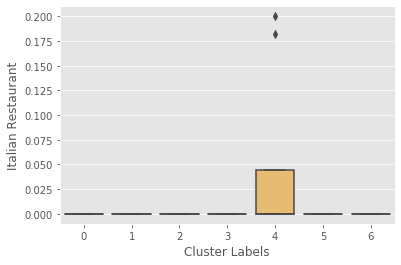

In [48]:
sns.boxplot(df1['Cluster Labels'], df1['Italian Restaurant'])